Реализовать нейронную сеть или стек из сверток (Concatenate) на сifar10.
оценить рост точности при увеличении ширины сети (больше ядер), больше нитей.
оценить рост точности при увеличении глубины сети (больше слоев)

In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

In [2]:
import tensorflow
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [5]:
y_test_show = y_test.copy()
class_names = ['самолет', 'автомобиль', 'птица', 'кот', 'олень',
               'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

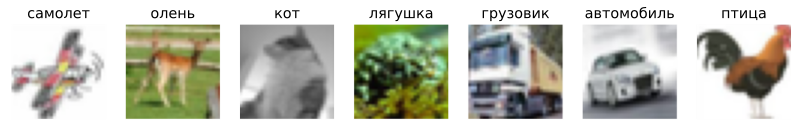

In [6]:
sample = [1211, 3445, 5744, 899, 1, 119, 1818]
N = len(sample)
plt.figure(figsize=(2 * N, 5))
for num, i in enumerate(sample, 1):
    plt.subplot(1, N, num)
    plt.imshow(X_train[i, :, :, :],)
    plt.xticks([])
    plt.yticks([])
    plt.title(class_names[y_train[i][0]])
    plt.grid(False)
plt.show()

In [7]:
# нормализация
x_train = X_train.astype('float32')
x_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0
# OHE
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

*************************************

In [8]:
def test_cnn(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_test: pd.DataFrame,
    n_layers: int = 2,  # число сверточных слоев (свертка-пулинг)
    kernel_size: int = 5,
    kernel_num: int = 20,
    n_epochs: int = 1500,
    batch_size: int = 1000,
    activation: str = 'Relu',
    optimizer=Adam(learning_rate=0.001),
):

    # конфигурирование слоев нейросети
    model = Sequential()

    # слои нейросети отвественные за свертку и max-pooling
    model.add(Conv2D(kernel_num, (kernel_size, kernel_size), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))),
    model.add(Dropout(0.25))

    if n_layers == 2:
        model.add(Conv2D(kernel_num*2, (kernel_size, kernel_size)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

    if n_layers == 3:
        model.add(Conv2D(kernel_num*3, (kernel_size, kernel_size), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

    if n_layers == 4:
        model.add(Conv2D(kernel_num*4, (kernel_size, kernel_size), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.35))

    if n_layers >= 5:
        model.add(Conv2D(kernel_num*5, (kernel_size, kernel_size), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.40))

    # полносвязные слои нейронной сети
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(optimizer=optimizer,
                  loss=categorical_crossentropy, metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
              validation_data=(X_test, y_test), verbose=0)
    return model

In [9]:
# тест влияния количества ядер на модель (два слоя (свертка-пулинг)- размер ядра -5х5)
# количество ядер увеличивает пропроционально от свертки к свертке!
# настравиватеся только количество ядер первой свертки!
x = np.arange(1, 101, 1)
result_dict_acc = {}
result_dict_loss = {}
for kernels in [8, 16, 32, 64]:
    model_2_5 = test_cnn(
        X_train,
        y_train,
        X_test,
        y_test,
        n_layers=2,  # число сверточных слоев (свертка-пулинг)
        kernel_size=5,
        kernel_num=kernels,
        n_epochs=100,
        batch_size=3000,
        activation='Relu',
        optimizer=Adam(learning_rate=0.001),
    )

    result_dict_acc[f'accuracy_{kernels}_kerneles'] = model_2_5.history.history['val_accuracy']
    result_dict_loss[f'loss_{kernels}_kerneles'] = model_2_5.history.history['val_loss']

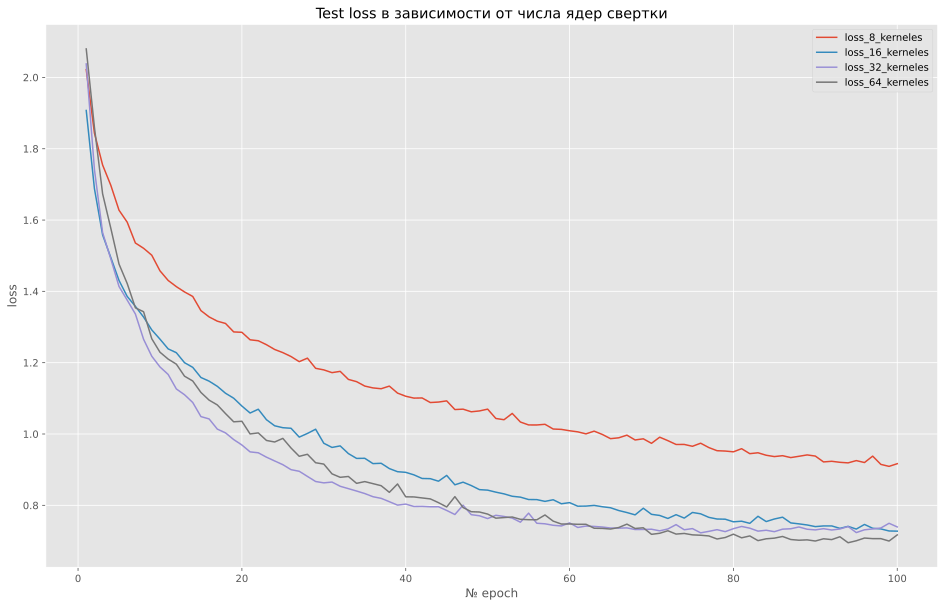

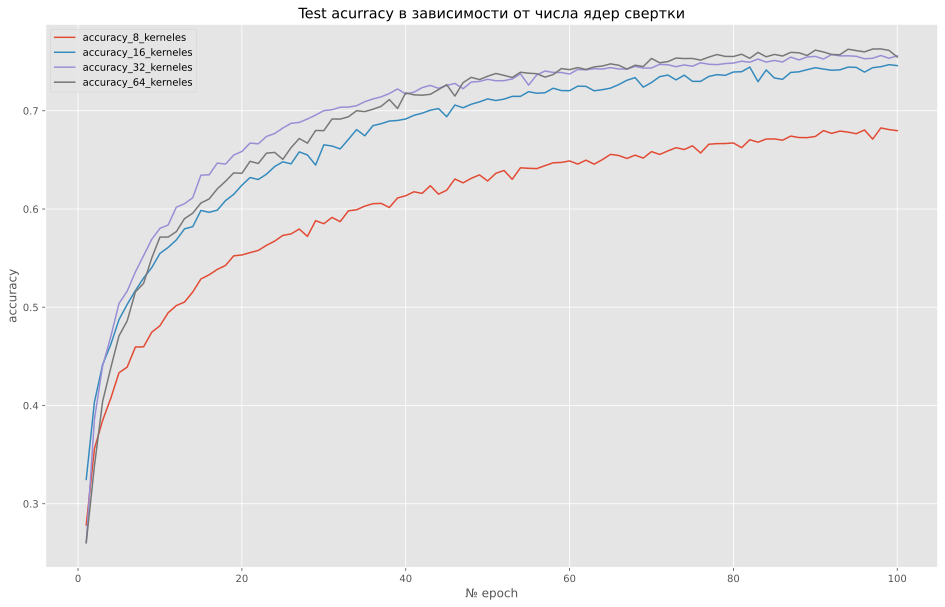

In [10]:
plt.figure(figsize=(16, 10))
for kernels in result_dict_loss:
    plt.plot(x, result_dict_loss[kernels], label=kernels)
plt.legend(loc='best')
plt.xlabel('№ epoch')
plt.ylabel('loss')
plt.title('Test loss в зависимости от числа ядер свертки')
plt.show()

plt.figure(figsize=(16, 10))
for kernels in result_dict_acc:
    plt.plot(x, result_dict_acc[kernels], label=kernels)
plt.legend(loc='best')
plt.xlabel('№ epoch')
plt.ylabel('accuracy')
plt.title('Test acurracy в зависимости от числа ядер свертки')
plt.show()

In [11]:
# тест влияния количества слоeв (свертка-пулинг)- размер ядра -5х5)

result_dict_acc = {}
result_dict_loss = {}
for n_layers in [1, 2, 3, 4, 5]:
    model_2_5 = test_cnn(
        X_train,
        y_train,
        X_test,
        y_test,
        n_layers=n_layers,  # число сверточных слоев (свертка-пулинг)
        kernel_size=5,
        kernel_num=16,
        n_epochs=100,
        batch_size=3000,
        activation='Relu',
        optimizer=Adam(learning_rate=0.001),
    )

    result_dict_acc[f'accuracy_{n_layers}_layers'] = model_2_5.history.history['val_accuracy']
    result_dict_loss[f'loss_{n_layers}_layers'] = model_2_5.history.history['val_loss']

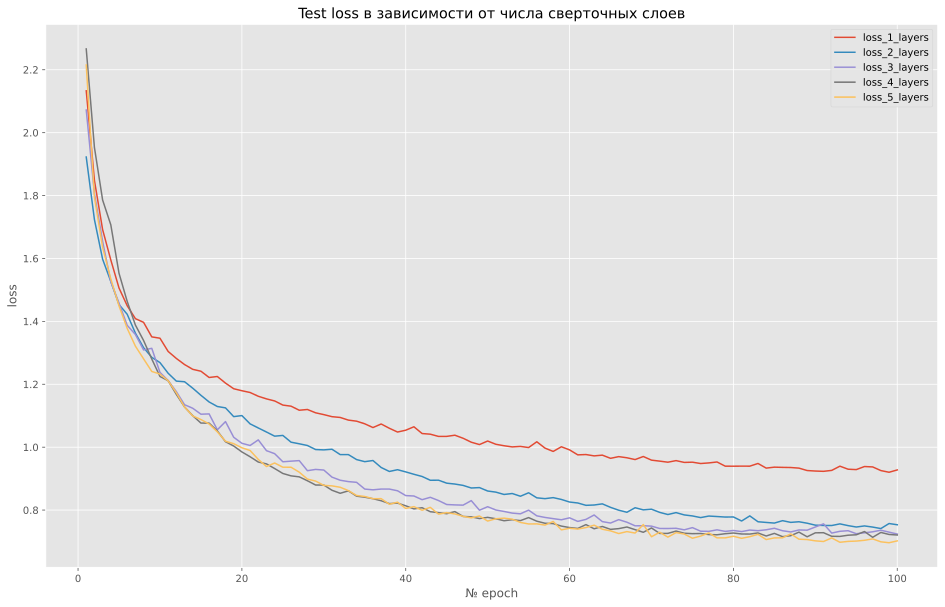

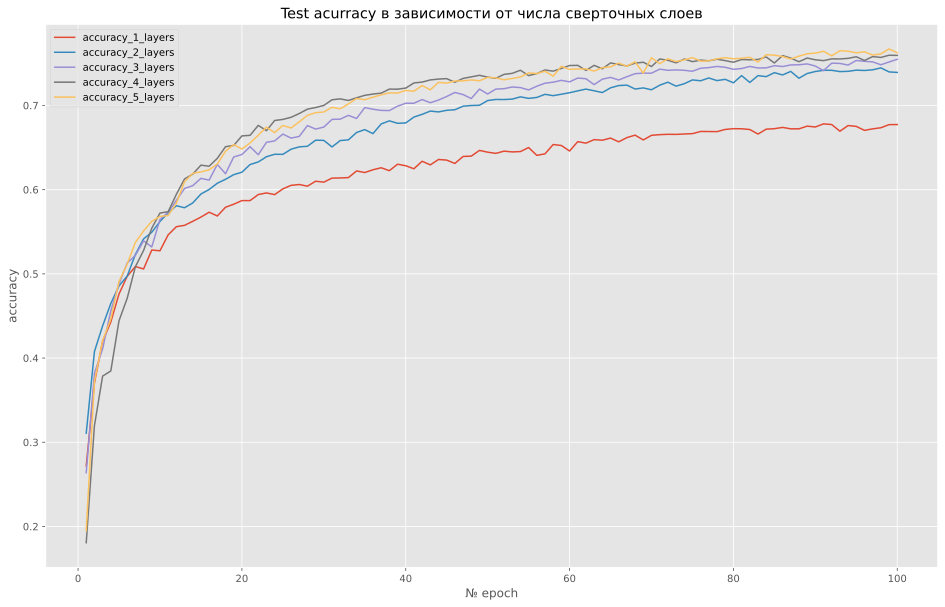

In [12]:
plt.figure(figsize=(16, 10))
for layers in result_dict_loss:
    plt.plot(x, result_dict_loss[layers], label=layers)
plt.legend(loc='best')
plt.xlabel('№ epoch')
plt.ylabel('loss')
plt.title('Test loss в зависимости от числа сверточных слоев')
plt.show()

plt.figure(figsize=(16, 10))
for layers in result_dict_acc:
    plt.plot(x, result_dict_acc[layers], label=layers)
plt.legend(loc='best')
plt.xlabel('№ epoch')
plt.ylabel('accuracy')
plt.title('Test acurracy в зависимости от числа сверточных слоев')
plt.show()

In [13]:
# тест влияния размера ядра свертки - для себя тестил

result_dict_acc = {}
result_dict_loss = {}
for kernel_size in [2, 3, 5]:
    model_2_5 = test_cnn(
        X_train,
        y_train,
        X_test,
        y_test,
        n_layers=2,  # число сверточных слоев (свертка-пулинг)
        kernel_size=kernel_size,
        kernel_num=16,
        n_epochs=100,
        batch_size=3000,
        activation='Relu',
        optimizer=Adam(learning_rate=0.001),
    )

    result_dict_acc[f'accuracy_{kernel_size}_kernel_size'] = model_2_5.history.history['val_accuracy']
    result_dict_loss[f'loss_{kernel_size}_kernel_size'] = model_2_5.history.history['val_loss']

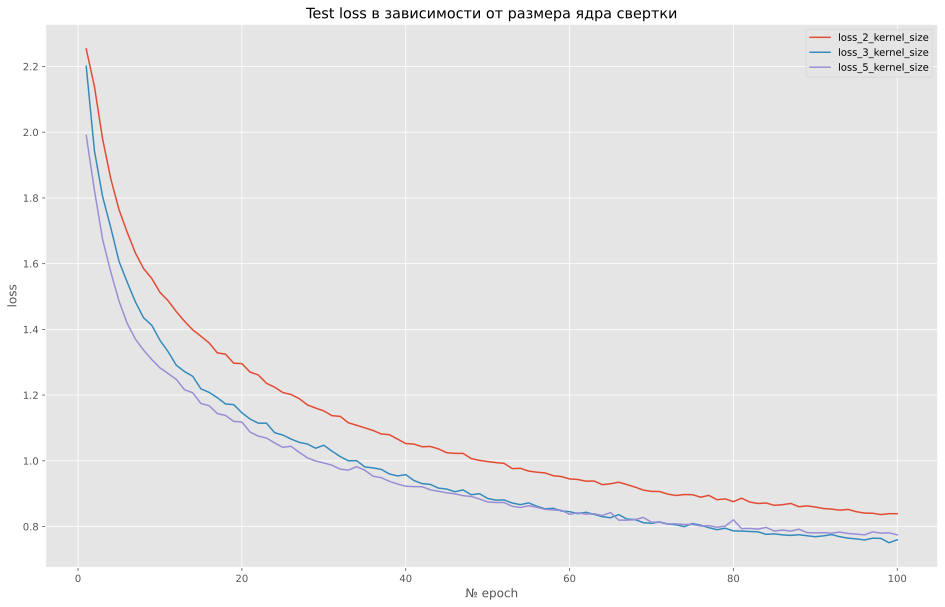

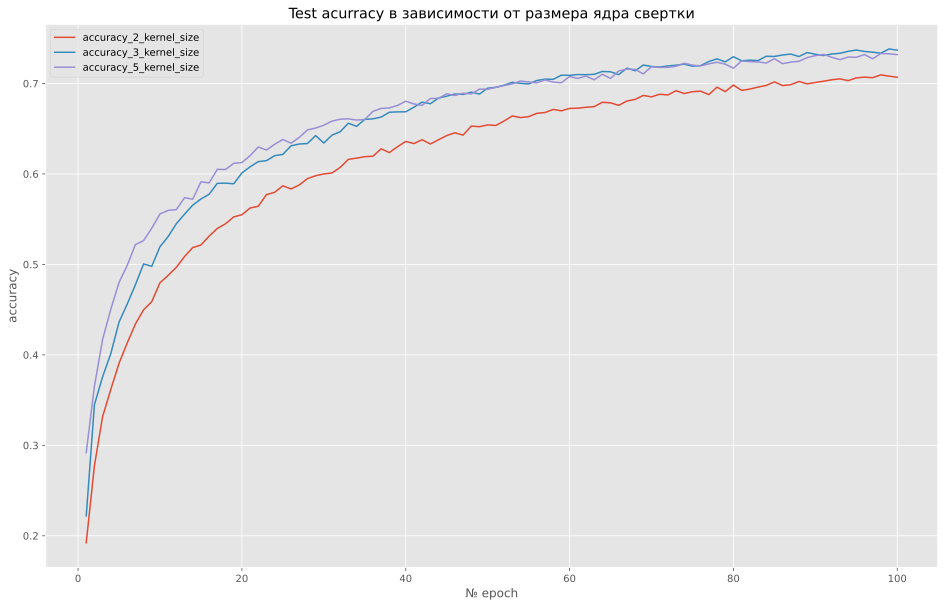

In [14]:
plt.figure(figsize=(16, 10))
for kernel_size in result_dict_loss:
    plt.plot(x, result_dict_loss[kernel_size], label=kernel_size)
plt.legend(loc='best')
plt.xlabel('№ epoch')
plt.ylabel('loss')
plt.title('Test loss в зависимости от размера ядра свертки')
plt.show()

plt.figure(figsize=(16, 10))
for kernel_size in result_dict_acc:
    plt.plot(x, result_dict_acc[kernel_size], label=kernel_size)
plt.legend(loc='best')
plt.xlabel('№ epoch')
plt.ylabel('accuracy')
plt.title('Test acurracy в зависимости от размера ядра свертки')
plt.show()

*******************************************

In [19]:
# финальный вариант
model = test_cnn(
    X_train,
    y_train,
    X_test,
    y_test,
    n_layers=5,  # число сверточных слоев (свертка-пулинг)
    kernel_size=3,
    kernel_num=64,
    n_epochs=100,
    batch_size=1000,
    activation='Relu',
    optimizer=Adam(learning_rate=0.001),
)

test_score = model.evaluate(X_test, y_test)
print("Test loss {:.4f}, accuracy {:.2f}%".format(
    test_score[0], test_score[1] * 100))

313/313 [==============================] - 2s 5ms/step - loss: 0.8598 - accuracy: 0.7688
Test loss 0.8598, accuracy 76.88%


In [20]:
y_pred = model.predict(X_test)
y_lbl = np.argmax(y_pred, axis=1)

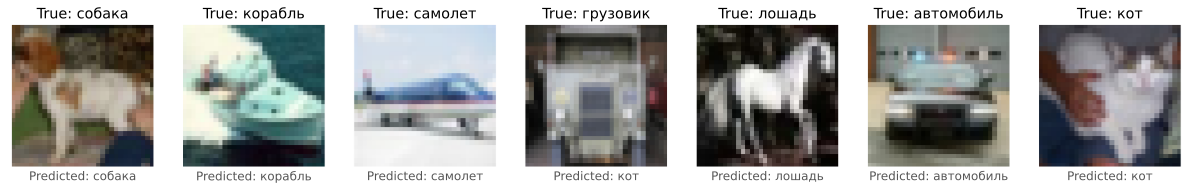

In [21]:
sample = [12, 144, 524, 707, 13, 66, 77]
N = len(sample)
plt.figure(figsize=(3 * N, 5))
for num, i in enumerate(sample, 1):
    plt.subplot(1, N, num)
    plt.imshow(X_test[i, :, :, :],)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f'Predicted: {class_names[y_lbl[i]]}')
    plt.title(f'True: {class_names[y_test_show[i][0]]}')
    plt.grid(False)
plt.show()

**Вывод:** увеличение числа ядер свертки и числа слоев "свертка-пулинг" улучшает качество модели (но до определенного момента).  Судя по графикам - 4 и 5 слои на данных изображениях, возможно, уже лишние, т.к. наступает момент, когда сворачивать уже нечего